In [685]:
import pandas as pd

# Veri dosyasını oku
df = pd.read_excel("/content/finalemlak2.xlsx")

pd.set_option('display.max_columns', None)


In [686]:
#-----------------------------------
#ozellik ekleme cikarma degistirme
#-----------------------------------

# Temizleme işlemleri
df['subCategory'] = df['subCategory'].replace("İmarlı - Konut", "Bahçe")
df['subCategory'] = df['subCategory'].replace("Konut+Ticaret", "Bahçe")
df['subCategory'] = df['subCategory'].replace("Bahçe", "Tarla")


#ozellik ekleme
df['kat_orani'] = df['daire_kati'] / (df['bina_kat_sayisi'] )




In [687]:
# netSqm_div_price hesapla
df['netSqm_div_price'] = df['price'] / df['netSqm']

# Filtre: subCategory 'Tarla' değilse, netSqm_div_price 1000-60000 arası olsun
mask = (df['subCategory'] != "Tarla") & (df['netSqm_div_price'] > 1000) & (df['netSqm_div_price'] < 60000)

# Tarla olanlar ise olduğu gibi bırak
mask_tarla = (df['subCategory'] == "Tarla")

# İki koşulu birleştir
df = df[mask | mask_tarla]

df = df.drop(columns=['netSqm_div_price']) #ezberleme olmasin diye sil


In [688]:
print(df.columns)


Index(['price', 'district', 'county', 'residence', 'room', 'livingRoom',
       'bathRoom', 'age', 'heating', 'fuel', 'build', 'buildState',
       'furnished', 'subCategory', 'netSqm', 'grossSqm', 'bina_kat_sayisi',
       'daire_kati', 'kuzey', 'guney', 'dogu', 'bati', 'goldeniz', 'bahceli',
       'havuzlu', 'kat_orani'],
      dtype='object')


In [689]:
kategorik_sutunlar = df.select_dtypes(include=['object', 'category', 'bool'])
print(kategorik_sutunlar.columns)

Index(['district', 'county', 'residence', 'heating', 'fuel', 'build',
       'buildState', 'furnished', 'subCategory'],
      dtype='object')


In [690]:
from sklearn.preprocessing import LabelEncoder

# Sayısallaştırılacak sütunlar
label_cols = ['district', 'county', 'residence', 'heating', 'fuel', 'build',
       'buildState', 'furnished', 'subCategory']

# Her sütun için encoder uygula
for col in label_cols:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])




In [691]:
# Bağımlı değişken (tahmin edilecek): price
y = df['price']

# Bağımsız değişkenler (özellikler)
X = df.drop('price', axis=1)


In [692]:
from sklearn.model_selection import train_test_split

# %80 eğitim, %20 test olacak şekilde ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [693]:
from sklearn.tree import DecisionTreeRegressor

# Modeli oluştur ve eğit
model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=10, random_state=42)

In [694]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Tahmin yap
y_pred = model.predict(X_test)

# Performans metrikleri
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Sonuçları yazdır
print(" Performans Skorları:")
print("MAE  (Ortalama Mutlak Hata):     ", round(mae, 2))
print("RMSE (Karekök Ortalama Hata):    ", round(rmse, 2))
print("R²   (Açıklanan Varyans Skoru):  ", round(r2, 4))


 Performans Skorları:
MAE  (Ortalama Mutlak Hata):      804035.53
RMSE (Karekök Ortalama Hata):     1602084.01
R²   (Açıklanan Varyans Skoru):   0.699


In [695]:
Q1 = df['price'].quantile(0.05)
Q3 = df['price'].quantile(0.95)
IQR = Q3 - Q1
mask = (df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)

df_clean = df[mask]

# Min ve max fiyat değerleri
min_price = df_clean['price'].min()
max_price = df_clean['price'].max()

print(f"Temizlenmiş veri setindeki en düşük fiyat: {min_price}")
print(f"Temizlenmiş veri setindeki en yüksek fiyat: {max_price}")


Temizlenmiş veri setindeki en düşük fiyat: 190000
Temizlenmiş veri setindeki en yüksek fiyat: 18000000


In [696]:
# ModelA: Aykırı değer temizliği VAR
# -----------------------------------
# Aykırı değer temizliği (IQR yöntemi)


y_clean = df_clean['price']
X_clean = df_clean.drop('price', axis=1)

# Eğitim/Test böl
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Model oluştur
modelA = DecisionTreeRegressor(random_state=42)
modelA.fit(X_train_clean, y_train_clean)

# Tahmin
y_pred_clean = modelA.predict(X_test_clean)

# Performans
print("MAE :", round(mean_absolute_error(y_test_clean, y_pred_clean), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_clean, y_pred_clean)), 2))
print("R²  :", round(r2_score(y_test_clean, y_pred_clean), 4))
# Hata oranı (yüzdelik)
non_zero_mask = y_test_clean != 0
hata_oranlari = 100 * abs((y_test_clean[non_zero_mask] - y_pred_clean[non_zero_mask]) / y_test_clean[non_zero_mask])
ortalama_hata_orani = hata_oranlari.mean()

print(" Ortalama Hata Oranı (%):", round(ortalama_hata_orani, 2))



MAE : 847583.75
RMSE: 1440815.98
R²  : 0.7248
 Ortalama Hata Oranı (%): 21.56


In [697]:
from sklearn.model_selection import GridSearchCV

# Parametre aralığı tanımla
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],  # None: derinlik sınırı yok
    'min_samples_split': [2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# GridSearch ile en iyi parametreleri bul
grid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid.fit(X_train_clean, y_train_clean)

# En iyi modelle tahmin yap
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_clean)

# Performans ölç
mae = mean_absolute_error(y_test_clean, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_best))
r2 = r2_score(y_test_clean, y_pred_best)

# Sonuçları yazdır
print("\n GridSearch ile En İyi Model:")
print("En iyi parametreler:", grid.best_params_)
print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²  :", round(r2, 4))

# Hata oranı (yüzdelik)
non_zero_mask = y_test_clean != 0
hata_oranlari = 100 * abs((y_test_clean[non_zero_mask] - y_pred_best[non_zero_mask]) / y_test_clean[non_zero_mask])
ortalama_hata_orani = hata_oranlari.mean()
print(" Ortalama Hata Oranı (%):", round(ortalama_hata_orani, 2))




 GridSearch ile En İyi Model:
En iyi parametreler: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 15}
MAE : 809777.11
RMSE: 1413492.46
R²  : 0.7352
 Ortalama Hata Oranı (%): 21.24


In [698]:
#ise yaramadi
#-------------------------------------------------------------
# Veri setindeki cok kullanilmayan oncemsiz sutunlari cikar
#-------------------------------------------------------------

# X_clean'in sadece bu blok için kullanılacak kopyasını oluştur
X_temp = X_clean.copy()

# Geçici modelle feature importanceları hesapla
model_temp = DecisionTreeRegressor(random_state=42)
model_temp.fit(X_temp, y_clean)

# %1'den düşük önem skoruna sahip sütunları belirle
low_impact_cols = [col for col, score in zip(X_temp.columns, model_temp.feature_importances_) if score < 0.005]

# Sadece bu blok için bu sütunları çıkar
X_temp = X_temp.drop(columns=low_impact_cols)

# Eğitim/Test böl
X_train_clean1, X_test_clean1, y_train_clean1, y_test_clean1 = train_test_split(X_temp, y_clean, test_size=0.2, random_state=42)

# Model oluştur (derinlik sınırlı)
model_clean = DecisionTreeRegressor(
    max_depth=9,
    min_samples_leaf=8,
    min_samples_split=2,
    random_state=42
)
model_clean.fit(X_train_clean1, y_train_clean1)

# Tahmin
y_pred_clean = model_clean.predict(X_test_clean1)

# Performans
print("\n📉 Sadece Bu Bloğa Özel Temizleme:")
print("Silinen Sütunlar:", low_impact_cols)
print("MAE :", round(mean_absolute_error(y_test_clean1, y_pred_clean), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_clean1, y_pred_clean)), 2))
print("R²  :", round(r2_score(y_test_clean1, y_pred_clean), 4))

from sklearn.metrics import mean_absolute_error

# Gerçek değerin sıfır olmadığı durumlar için filtrele
non_zero_mask = y_test_clean1 != 0
# Hata oranlarını hesapla (yüzde olarak)
hata_oranlari = 100 * abs((y_test_clean1[non_zero_mask] - y_pred_clean[non_zero_mask]) / y_test_clean1[non_zero_mask])
ortalama_hata_orani = hata_oranlari.mean()
print(" Ortalama Hata Oranı: %", round(ortalama_hata_orani, 2))



📉 Sadece Bu Bloğa Özel Temizleme:
Silinen Sütunlar: ['livingRoom', 'fuel', 'build', 'buildState', 'furnished', 'daire_kati', 'kuzey', 'guney', 'dogu', 'bati', 'goldeniz', 'bahceli']
MAE : 759849.8
RMSE: 1402490.45
R²  : 0.7393
 Ortalama Hata Oranı: % 20.39


In [699]:
#deneme yerri
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modeli oluştur
model_final = DecisionTreeRegressor(
    max_depth=6,
    min_samples_leaf=4,
    min_samples_split=2,
    random_state=42
)

# Eğit
model_final.fit(X_train_clean, y_train_clean)

# Tahmin
y_pred_final = model_final.predict(X_test_clean)

# Performans ölç
print("MAE :", round(mean_absolute_error(y_test_clean, y_pred_final), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_clean, y_pred_final)), 2))
print("R²  :", round(r2_score(y_test_clean, y_pred_final), 4))

# Ortalama hata oranı (%), gerçek değer sıfır olmayanlar için
non_zero_mask = y_test_clean != 0
hata_oranlari = 100 * abs((y_test_clean[non_zero_mask] - y_pred_final[non_zero_mask]) / y_test_clean[non_zero_mask])
ortalama_hata_orani = hata_oranlari.mean()
print("Ortalama Hata Oranı (%):", round(ortalama_hata_orani, 2))




MAE : 835180.03
RMSE: 1512508.36
R²  : 0.6968
Ortalama Hata Oranı (%): 22.15


In [700]:
#ise yaramadi
#----------------------
#Log Donusumu yapiyorum
#----------------------

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Log dönüşümlü hedef değişken
y_clean_log = np.log1p(y_clean)

# 2. Eğitim/test böl
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_clean, y_clean_log, test_size=0.2, random_state=42)

# 3. Modeli oluştur
model_log = DecisionTreeRegressor(
    max_depth=9,
    min_samples_leaf=8,
    min_samples_split=2,
    random_state=42
)
model_log.fit(X_train_log, y_train_log)

# 4. Tahmin (log aralığında)
y_pred_log = model_log.predict(X_test_log)

# 5. Tahminleri ve gerçek değerleri orijinal ölçeğe çevir
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

# 6. Performans ölç
print("Log Dönüşümlü Model Performansı:")
print("MAE :", round(mean_absolute_error(y_true, y_pred), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))
print("R²  :", round(r2_score(y_true, y_pred), 4))

# 7. Ortalama hata oranı (%), gerçek değer sıfır olmayanlar için
non_zero_mask = y_true != 0
hata_oranlari = 100 * abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
ortalama_hata_orani = hata_oranlari.mean()
print("Ortalama Hata Oranı (%):", round(ortalama_hata_orani, 2))


Log Dönüşümlü Model Performansı:
MAE : 821251.84
RMSE: 1405653.79
R²  : 0.7381
Ortalama Hata Oranı (%): 22.11


# EN IYI MODEL UZERINDE TESTLER


> Blok alıntı ekle



In [866]:
df = pd.read_excel("/content/finalemlak2.xlsx")


In [867]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# netSqm_div_price hesapla
df['netSqm_div_price'] = df['price'] / df['netSqm']

# Filtre: subCategory 'Tarla' değilse, netSqm_div_price 1000-60000 arası olsun
mask = (df['subCategory'] != "Tarla") & (df['netSqm_div_price'] > 1000) & (df['netSqm_div_price'] < 60000)

# Tarla olanlar ise olduğu gibi bırak
mask_tarla = (df['subCategory'] == "Tarla")

# İki koşulu birleştir
df = df[mask | mask_tarla]

df = df.drop(columns=['netSqm_div_price']) #ezberleme olmasin diye sil

df['subCategory'] = df['subCategory'].replace("İmarlı - Konut", "Bahçe")
df['subCategory'] = df['subCategory'].replace("Konut+Ticaret", "Bahçe")
df['subCategory'] = df['subCategory'].replace("Bahçe", "Tarla")


#ozellik ekleme
df['kat_orani'] = df['daire_kati'] / (df['bina_kat_sayisi'] )

Q1 = df['price'].quantile(0.05)
Q3 = df['price'].quantile(0.95)
IQR = Q3 - Q1
mask = (df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)

df = df[mask]


# Sayısallaştırılacak sütunlar
label_cols = ['district', 'county', 'residence', 'heating', 'fuel', 'build',
       'buildState', 'furnished', 'subCategory']

# Her sütun için encoder uygula
for col in label_cols:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])




In [868]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Veri hazırlanıyor
X = df.drop(columns=['price'])
y = df['price']

# Eğitim ve test seti
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model oluştur ve eğit
model = DecisionTreeRegressor(
    max_depth=7,
    min_samples_leaf=1,
    min_samples_split=15,
    random_state=42
)
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Performans metrikleri
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Sonuçları yazdır
print(" Performans Skorları:")
print("MAE  (Ortalama Mutlak Hata):     ", round(mae, 2))
print("RMSE (Karekök Ortalama Hata):    ", round(rmse, 2))
print("R²   (Açıklanan Varyans Skoru):  ", round(r2, 4))


 Performans Skorları:
MAE  (Ortalama Mutlak Hata):      741720.77
RMSE (Karekök Ortalama Hata):     1219581.14
R²   (Açıklanan Varyans Skoru):   0.7486


In [869]:
import pandas as pd
import numpy as np

# İlk 10 örnek için gerçek ve tahmin değerleri
gercek = y_test.values[:10]
tahmin = y_pred[:10]

# DataFrame oluştur
comparison_df = pd.DataFrame({
    'Gerçek Fiyat (Milyon)': (gercek / 1_000_000).round(3),
    'Tahmin Edilen Fiyat (Milyon)': (tahmin / 1_000_000).round(3),
    'Hata Oranı (%)': (np.abs(gercek - tahmin) / gercek * 100).round(2)
})

print(comparison_df)


   Gerçek Fiyat (Milyon)  Tahmin Edilen Fiyat (Milyon)  Hata Oranı (%)
0                  2.500                         2.283            8.66
1                  2.800                         1.310           53.21
2                  7.000                         5.066           27.63
3                  2.450                         2.302            6.06
4                  2.450                         1.904           22.30
5                  4.150                         4.244            2.26
6                  4.199                         3.434           18.22
7                  5.000                         1.904           61.93
8                  2.000                         2.302           15.08
9                  1.550                         1.634            5.40


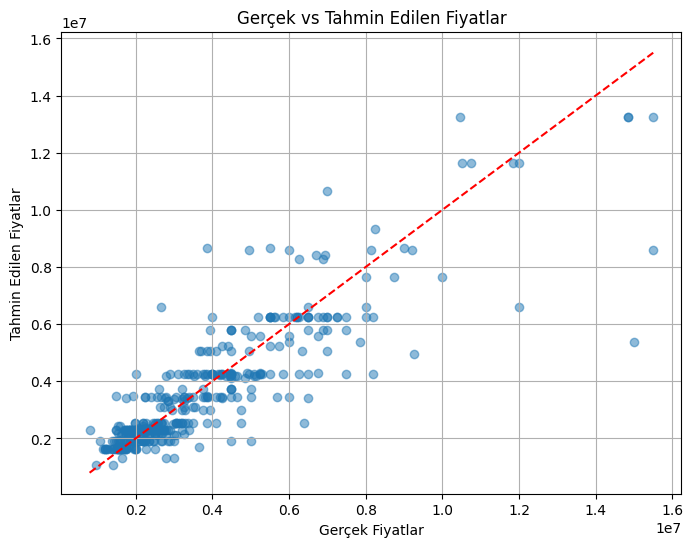

In [870]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Gerçek ve tahmin edilen değerlerin scatter plot'u
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal doğrultu
plt.xlabel('Gerçek Fiyatlar')
plt.ylabel('Tahmin Edilen Fiyatlar')
plt.title('Gerçek vs Tahmin Edilen Fiyatlar')
plt.grid(True)
plt.show()


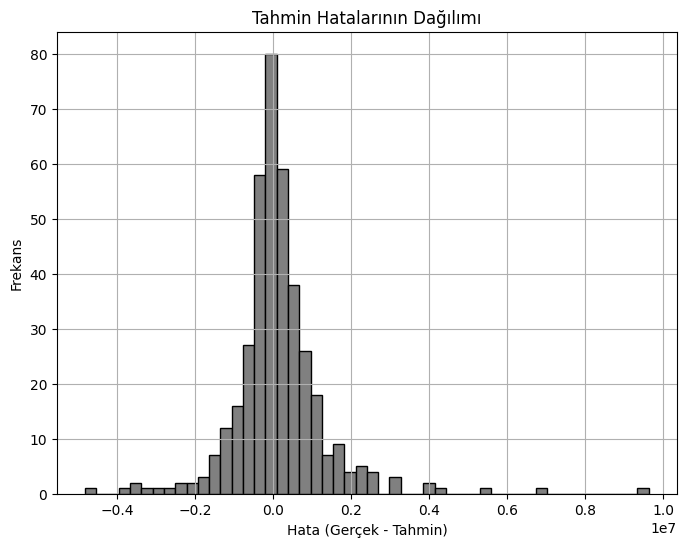

In [871]:
# 2. Hata dağılımı (Residuals)
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, color='gray', edgecolor='black')
plt.xlabel('Hata (Gerçek - Tahmin)')
plt.ylabel('Frekans')
plt.title('Tahmin Hatalarının Dağılımı')
plt.grid(True)
plt.show()

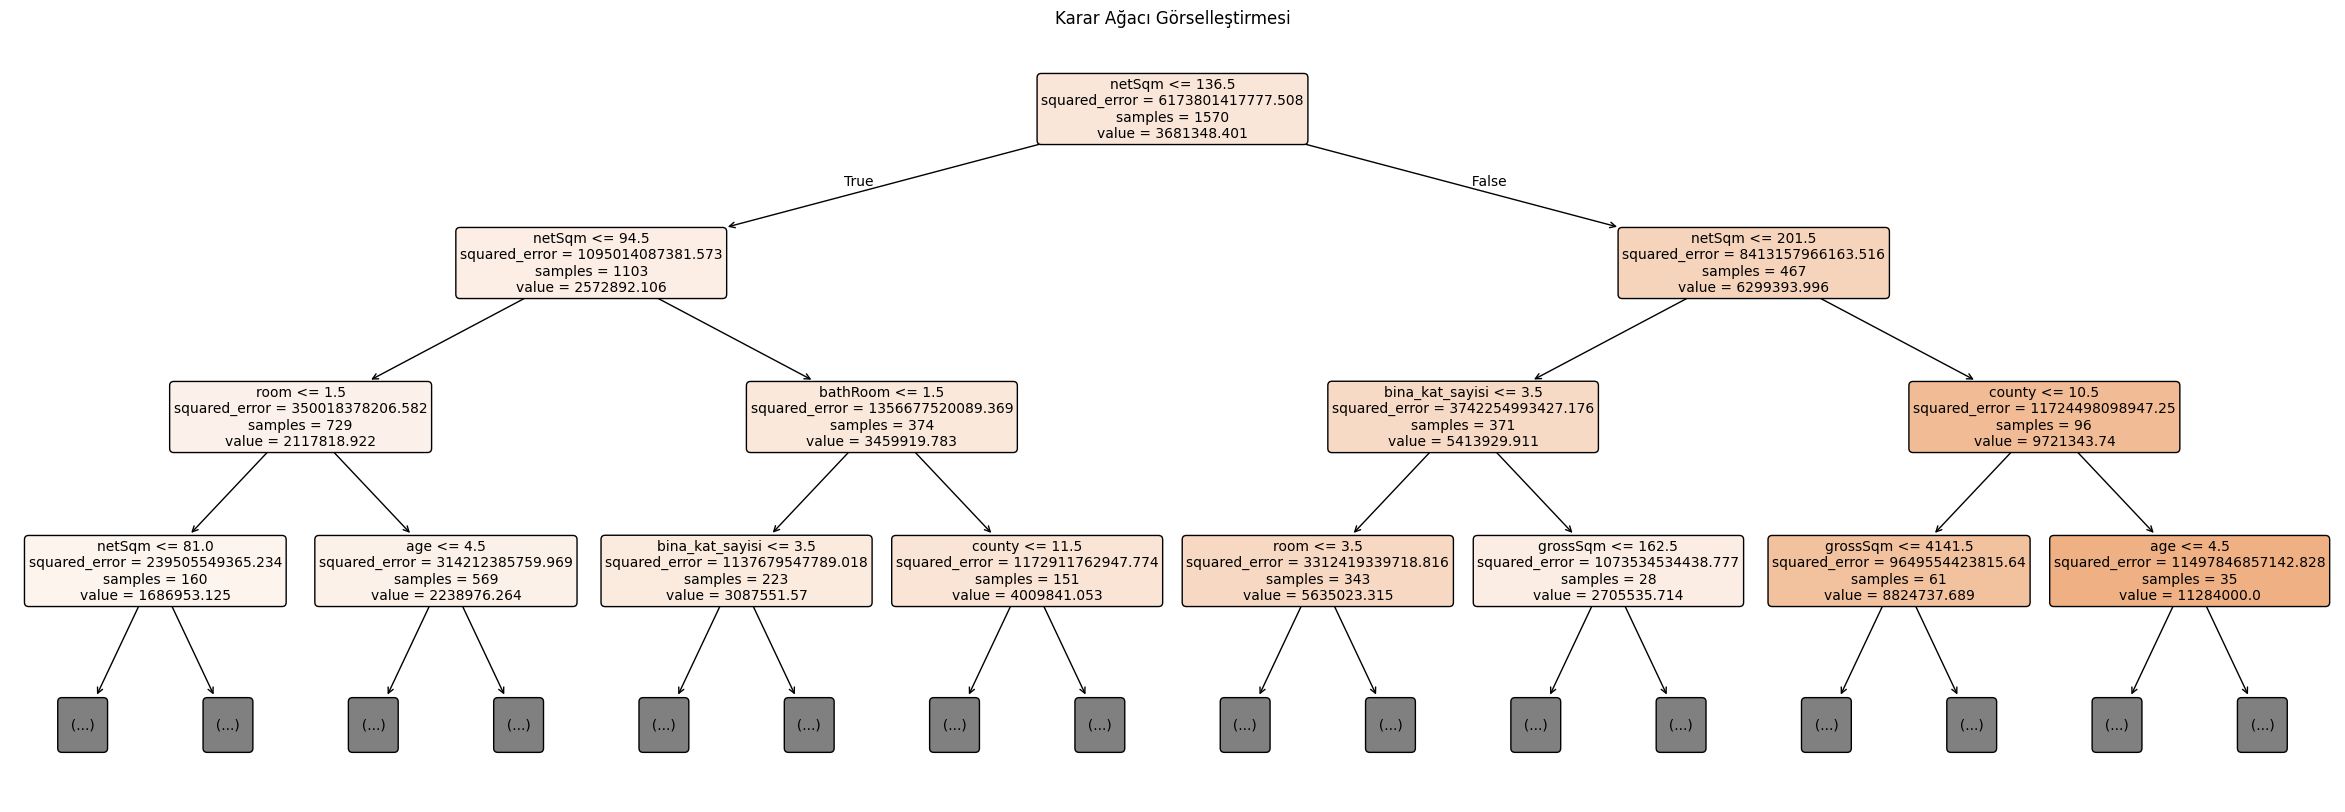

In [872]:
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt

# 1. Karar ağacı görselleştirme
plt.figure(figsize=(30,10))
plot_tree(model,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)
plt.title('Karar Ağacı Görselleştirmesi')
plt.show()



En Önemli 10 Özellik ve Önem Oranları:
netSqm             0.780220
grossSqm           0.038094
county             0.037069
subCategory        0.034426
bina_kat_sayisi    0.031283
room               0.026234
age                0.013988
havuzlu            0.010927
bathRoom           0.009213
district           0.007311
dtype: float64


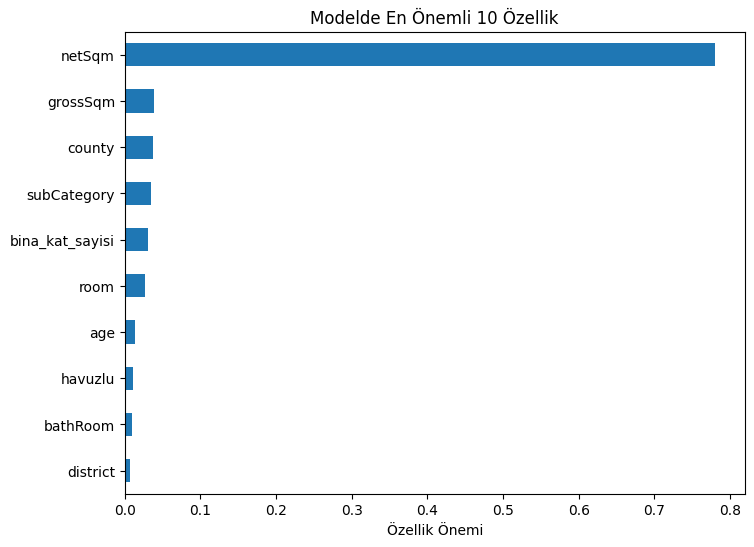

In [873]:
import pandas as pd

# Özellik önem oranlarını çıkar ve DataFrame yap
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

# Azalan sırada ilk 10 önemli özelliği göster
top_features = feat_importances.sort_values(ascending=False).head(10)

print("En Önemli 10 Özellik ve Önem Oranları:")
print(top_features)

# İstersen grafikle görselleştir
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
top_features.plot(kind='barh')
plt.gca().invert_yaxis()  # En önemlisi üstte olsun diye
plt.xlabel('Özellik Önemi')
plt.title('Modelde En Önemli 10 Özellik')
plt.show()


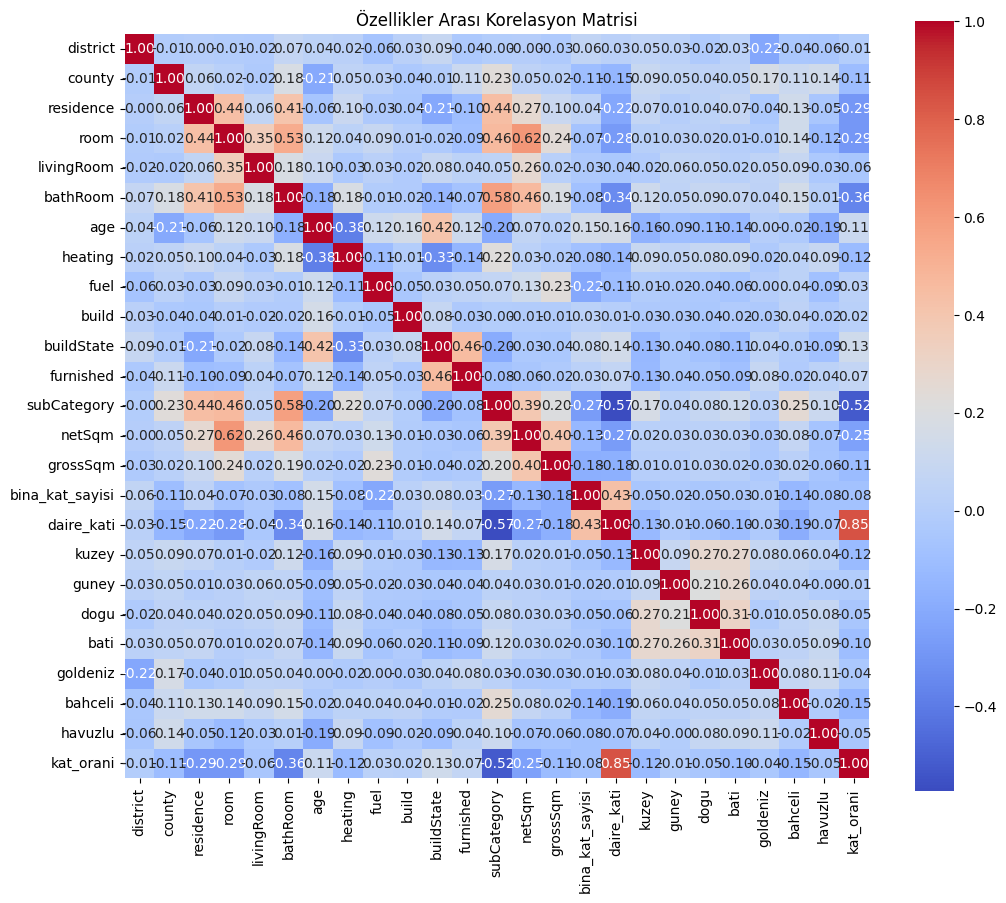

In [874]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Özellikler Arası Korelasyon Matrisi')
plt.show()


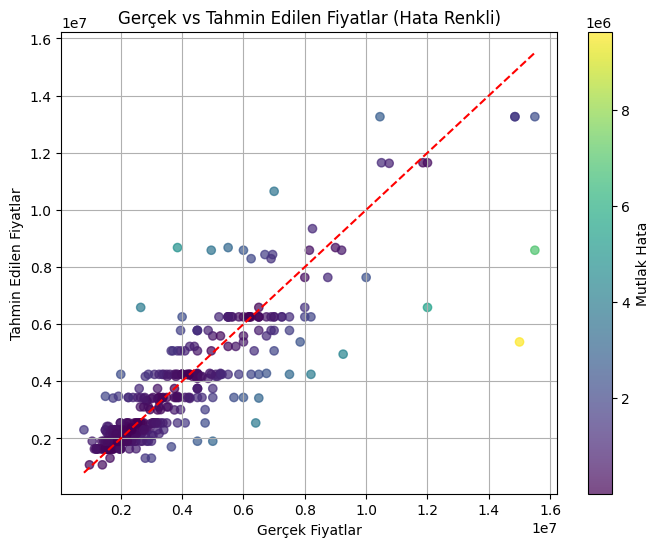

In [875]:
import matplotlib.pyplot as plt
import numpy as np

residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sc = plt.scatter(y_test, y_pred, c=np.abs(residuals), cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Mutlak Hata')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Gerçek Fiyatlar')
plt.ylabel('Tahmin Edilen Fiyatlar')
plt.title('Gerçek vs Tahmin Edilen Fiyatlar (Hata Renkli)')
plt.grid(True)
plt.show()


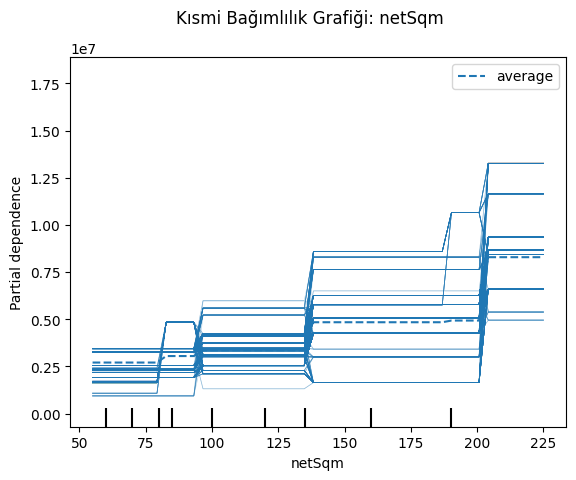

In [877]:
from sklearn.inspection import PartialDependenceDisplay

# En önemli özellik ismini al
top_feature = feat_importances.index[0]

PartialDependenceDisplay.from_estimator(model, X, [top_feature], kind='both', subsample=1000, grid_resolution=50)
plt.suptitle(f'Kısmi Bağımlılık Grafiği: {top_feature}')
plt.show()
